In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib widget
    
from copy import deepcopy
from tqdm import tqdm

import torch
import torch.nn as nn
from matplotlib import pyplot as plt

import tasks
import models

from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"

filepath = Path("~/Documents/Kempner/MCN2024/jobs/")
filepath = filepath.expanduser()

from analysis import load_perturbation, load_job, measure_choice, test_and_perturb, create_cdf_proportional_bins, fit_sigmoid, sigmoid

edges = create_cdf_proportional_bins(30, std_dev=1, range_multiplier=2.5)
centers = (edges[1:] + edges[:-1]) / 2

In [21]:
# Load trained model and results

jobid = 9
model_index = 0
model, results = load_job(jobid, model_index=model_index)

args = results["args"]
task_params = results["task"]
train_loss = results["train_loss"]

task = tasks.ContextualGoNogo(
    args["input_dimensions"],
    args["end_sigma"],
    num_contexts=task_params["num_contexts"],
    stim_time=task_params["stim_time"],
    delay_time=args["end_delay"],
    decision_time=task_params["decision_time"],
)
task.cursors = task_params["cursors"]

if args["network_type"] == "Gain":
    model_constructor = models.GainRNN
elif args["network_type"] == "Tau":
    model_constructor = models.TauRNN
else:
    raise ValueError("Unknown network type")

net = model_constructor(
    task.input_dimensionality(),
    args["num_neurons"],
    task.output_dimensionality(),
    input_rank=args["input_rank"],
    recurrent_rank=args["recurrent_rank"]
)

net.load_state_dict(model)

<All keys matched successfully>

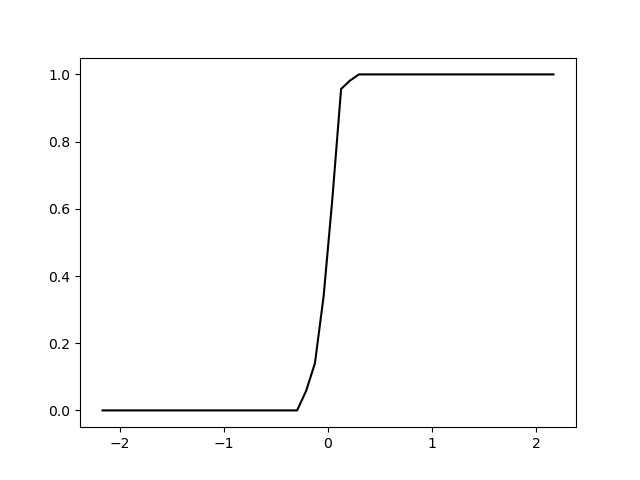

In [49]:
pnet = deepcopy(net)
pnet = pnet.to(device)

#perturb the model
pnet.hidden_tau.data = pnet.hidden_tau.data + 0.2 * torch.randn_like(pnet.hidden_tau.data) * pnet.hidden_tau.data

X, target, params = task.generate_data(1000, source_floor=0.0)
s_target = torch.gather(params["s_empirical"], 1, params["context_idx"].unsqueeze(1)).squeeze(1)
outputs, hidden = pnet(X, return_hidden=True)
loss = nn.MSELoss(reduction="none")(outputs, target)
choice, evidence = measure_choice(task, outputs)

s_index = torch.bucketize(s_target, edges)
psycho = torch.zeros(len(centers))
for i in range(len(centers)):
    if torch.sum(s_index == i) > 0:
        psycho[i] = torch.mean(choice[s_index == i].float())

plt.close('all')
plt.plot(centers, psycho, c='k', label="data")   
plt.show()

In [3]:
perturb_ratios = torch.linspace(0.5, 1, 2)
num_ratios = len(perturb_ratios)
num_trials = 10

loss_intrinsic = torch.zeros(num_ratios, num_trials)
loss_receptive = torch.zeros(num_ratios, num_trials)
loss_projective = torch.zeros(num_ratios, num_trials)

psychometric_edges = create_cdf_proportional_bins(30, std_dev=1, range_multiplier=2.5)
psychometric_centers = (psychometric_edges[1:] + psychometric_edges[:-1]) / 2

for i, perturb_ratio in enumerate(tqdm(perturb_ratios)):
    loss_intrinsic[i], x = test_and_perturb(net, task, psychometric_edges, perturb_ratio=perturb_ratio, perturb_target="intrinsic", num_trials=num_trials)
    loss_receptive[i], x = test_and_perturb(net, task, psychometric_edges, perturb_ratio=perturb_ratio, perturb_target="receptive", num_trials=num_trials)
    loss_projective[i], x = test_and_perturb(net, task, psychometric_edges, perturb_ratio=perturb_ratio, perturb_target="projective", num_trials=num_trials)

  0%|          | 0/2 [00:00<?, ?it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
ERROR:tornado.general:SEND Error: Host unreachable
100%|██████████| 2/2 [03:40<00:00, 110.44s/it]


In [22]:
perturb = load_perturbation(8, suffix="more_trials")
perturb_ratios = perturb["perturb_ratios"]
psychometric_edges = perturb["psychometric_edges"]
psychometric_centers = (psychometric_edges[1:] + psychometric_edges[:-1]) / 2
model_indices = perturb["model_indices"]
loss_intrinsic = perturb["loss_intrinsic"]
loss_receptive = perturb["loss_receptive"]
loss_projective = perturb["loss_projective"]
psychometric_intrinsic = perturb["psychometric_intrinsic"]
psychometric_receptive = perturb["psychometric_receptive"]
psychometric_projective = perturb["psychometric_projective"]

tensor(0.1000)


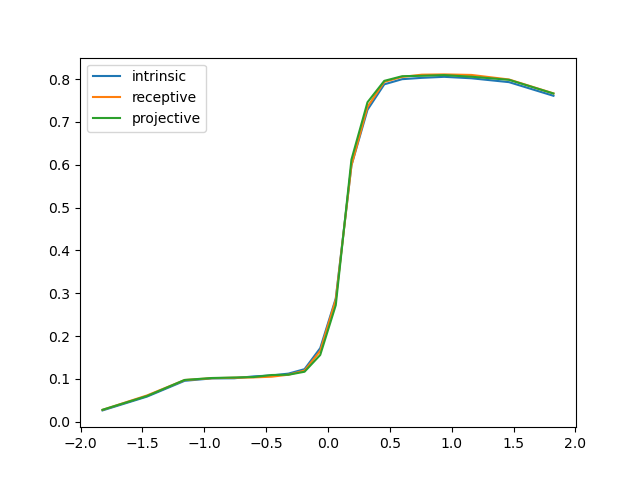

In [23]:
ii = 1
print(perturb_ratios[ii])
plt.close('all')
plt.plot(psychometric_centers, torch.mean(psychometric_intrinsic, dim=0)[ii], label="intrinsic")
plt.plot(psychometric_centers, torch.mean(psychometric_receptive, dim=0)[ii], label="receptive")
plt.plot(psychometric_centers, torch.mean(psychometric_projective, dim=0)[ii], label="projective")
plt.legend()
plt.show()

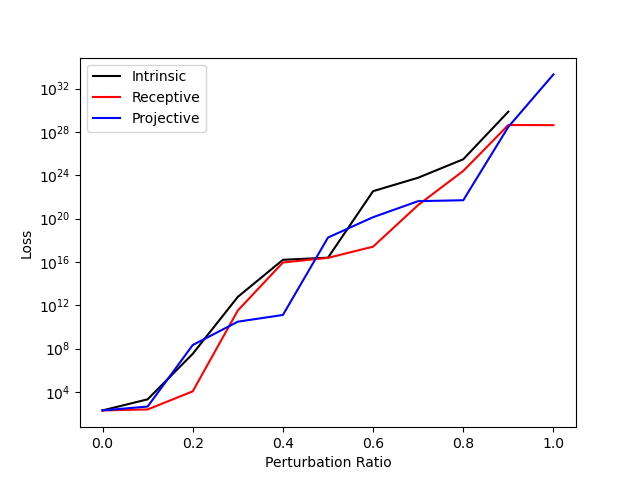

In [24]:
cols = 'krb'

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(perturb_ratios, loss_intrinsic.mean(dim=(0, 2)), label="Intrinsic", c=cols[0])
ax.plot(perturb_ratios, loss_receptive.mean(dim=(0, 2)), label="Receptive", c=cols[1])
ax.plot(perturb_ratios, loss_projective.mean(dim=(0, 2)), label="Projective", c=cols[2])
# ax.fill_between(perturb_ratios, loss_intrinsic.mean(dim=1) - loss_intrinsic.std(dim=1), loss_intrinsic.mean(dim=1) + loss_intrinsic.std(dim=1), alpha=0.5, color=cols[0])
# ax.fill_between(perturb_ratios, loss_receptive.mean(dim=1) - loss_receptive.std(dim=1), loss_receptive.mean(dim=1) + loss_receptive.std(dim=1), alpha=0.5, color=cols[1])
# ax.fill_between(perturb_ratios, loss_projective.mean(dim=1) - loss_projective.std(dim=1), loss_projective.mean(dim=1) + loss_projective.std(dim=1), alpha=0.5, color=cols[2])
# ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Perturbation Ratio")
ax.set_ylabel("Loss")
ax.legend()
plt.show()